In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(r'/home/jovyan/work/data-analysis/output/metrics.csv')
df = pd.DataFrame(data)
df['title'] = df['level_0']
attack_series = []
attack_IDs = []
dimensions_series = []
for _, row in df.iterrows():
    attack_series.append(row['level_1'].split('/')[-2])

df['attack'] = attack_series

for _, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))
    dimensions_series.append(dimension)
    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

df['attack_ID'] = attack_IDs
df['dimension'] = dimensions_series
df = df.drop(['Unnamed: 0',
         'temporal_canny-series',
         'temporal_cross_correlation-series', 
         'temporal_difference-series', 
         'temporal_histogram_distance-series', 
         'temporal_histogram_distance-cosine',
         'level_0', 
         'level_1'],axis=1)

# Data Visualization

In [3]:
df.head(25)

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,title,attack,attack_ID,dimension
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p,1,1080
1,0.000566,0.670932,7.154334e-07,0.186423,0.000021,0.585142,0.587441,78.516691,../../data/1080p/-8ygLPzgpsg.mp4,1080p_watermark,0,1080
2,0.001139,1.866004,5.874493e-04,3.274284,0.000036,0.361467,0.048735,3.019776,../../data/1080p/-8ygLPzgpsg.mp4,1080p_flip_vertical,0,1080
3,0.001072,1.812684,8.232710e-04,4.191308,0.000043,0.403333,0.091211,1.929483,../../data/1080p/-8ygLPzgpsg.mp4,1080p_rotate_90_clockwise,0,1080
4,0.000633,0.630162,8.913559e-07,0.385323,0.000296,1.154801,11.787850,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_vignette,0,1080
5,0.000493,0.556471,6.946701e-06,0.127974,0.000175,1.431690,16.136381,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_black_and_white,0,1080
6,0.000671,0.647693,3.210575e-08,0.012719,0.000474,2.022201,0.266372,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_low_bitrate_4,0,1080
7,0.000601,0.615467,3.528216e-09,0.005353,0.000135,0.702022,0.080409,96.411326,../../data/1080p/-8ygLPzgpsg.mp4,720p,1,720
8,0.000672,0.648275,8.818017e-07,0.391206,0.000490,1.339839,11.799543,NaN,../../data/1080p/-8ygLPzgpsg.mp4,720p_vignette,0,720
9,0.000624,0.627251,6.814093e-06,0.131143,0.000352,1.794147,16.145431,NaN,../../data/1080p/-8ygLPzgpsg.mp4,720p_black_and_white,0,720


In [4]:
df.describe()

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension
count,5796.000000,5796.000000,5.796000e+03,5796.000000,5796.000000,5796.000000,5796.000000,3174.000000,5796.000000,5796.000000
mean,0.124845,12196.617817,2.942489e-03,1.671773,0.021534,3.302123,5.355903,40.343494,0.142857,504.000000
std,0.246705,50237.227818,1.237253e-02,2.582384,0.070417,2.904630,9.728277,40.267544,0.349957,316.001944
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.000000
25%,0.000873,1.099166,3.474633e-07,0.103534,0.000725,1.348963,0.165798,1.475565,0.000000,240.000000
50%,0.003933,3.552987,4.852876e-06,0.352134,0.003272,2.496744,0.604480,9.992767,0.000000,420.000000
75%,0.090100,12.470781,3.877885e-04,2.447800,0.013115,4.241309,5.357450,84.832563,0.000000,720.000000
max,0.974069,378978.958427,1.665425e-01,12.605094,0.823593,22.774383,56.174166,99.590587,1.000000,1080.000000


In [5]:
df_corr = df.corr()

In [6]:
plt.figure(figsize=(10,10))
corr = df_corr.corr('spearman')
corr.style.background_gradient().set_precision(2)

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension
temporal_canny-cosine,1,0.88,0.42,0.49,0.48,0.079,0.091,-0.35,-0.16,-0.079
temporal_canny-euclidean,0.88,1,0.22,0.41,0.59,0.13,0.079,-0.24,-0.14,-0.19
temporal_cross_correlation-cosine,0.42,0.22,1,0.92,-0.33,-0.62,-0.7,-0.94,-0.28,0.56
temporal_cross_correlation-euclidean,0.49,0.41,0.92,1,-0.16,-0.43,-0.54,-0.95,-0.49,0.36
temporal_difference-cosine,0.48,0.59,-0.33,-0.16,1,0.73,0.47,0.36,0.055,-0.73
temporal_difference-euclidean,0.079,0.13,-0.62,-0.43,0.73,1,0.73,0.55,-0.2,-0.94
temporal_histogram_distance-euclidean,0.091,0.079,-0.7,-0.54,0.47,0.73,1,0.59,-0.067,-0.7
vmaf,-0.35,-0.24,-0.94,-0.95,0.36,0.55,0.59,1,0.47,-0.45
attack_ID,-0.16,-0.14,-0.28,-0.49,0.055,-0.2,-0.067,0.47,1,0.28
dimension,-0.079,-0.19,0.56,0.36,-0.73,-0.94,-0.7,-0.45,0.28,1


<Figure size 720x720 with 0 Axes>

# Define model (Keras neural network)

We choose the input of our model (we try to make balanced dataset)

In [7]:
int(df.shape[0]*0.8)

4636

In [8]:
num_train = int(df.shape[0]*0.8)

df_train_all = df[0:num_train]
df_train_1 = df_train_all[df_train_all['attack_ID'] == 1]
df_train_0 = df_train_all[df_train_all['attack_ID'] == 0]
df_sample = df_train_0.sample(int(df_train_0.shape[0]*0.95))
df_train = df_train_1.append(df_sample)
df_train = df_train.sample(frac=1)

df_test_all = df[num_train:]
df_test_1 = df_test_all[df_test_all['attack_ID'] == 1]
df_test_0 = df_test_all[df_test_all['attack_ID'] == 0]
df_sample_test = df_test_0.sample(int(df_test_0.shape[0]*0.95))
df_test = df_test_1.append(df_sample_test)
df_test = df_test.sample(frac=1)

X_train = df_train.drop(['title',
                         'attack', 
                         'attack_ID',
                         'vmaf'],axis=1)
y_train = df_train['attack_ID']
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = df_test.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'vmaf'],axis=1)
y_test = df_test['attack_ID']
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)



First we define a model where we take all variables :

In [9]:
print('TRAIN:', X_train.shape)
print('TEST:', X_test.shape)

TRAIN: (4437, 8)
TEST: (1110, 8)


In [10]:
def model():
    global network_history
    model = Sequential()
    model.add(Dense(32,input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    
    network_history = model.fit(X_train, y_train, batch_size=128, epochs=2000, verbose=0)
    return model

model = model()

visualization loss and accuracy

In [11]:
print(model.metrics_names)

['loss', 'acc']


In [12]:
def plot_history(network_history,title='Loss and accuracy (Keras model)'):
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    #plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(212)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    #plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

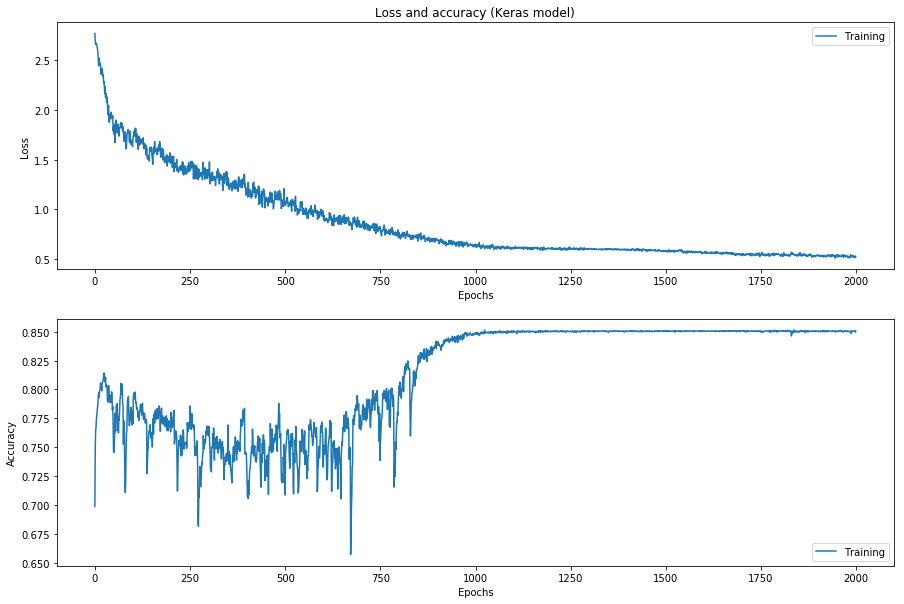

In [13]:
plot_history(network_history)

In [14]:
print(model.metrics_names)
model.evaluate(X_test, y_test)


['loss', 'acc']
1110/1110 [==============================] - 0s 58us/step


[0.56371315591507132, 0.85135135188833011]

In [15]:
prediction = model.predict(X_test)

(array([ 571.,   33.,   35.,   11.,   13.,   35.,   19.,   13.,   63.,  317.]),
 array([ 0.        ,  0.03488539,  0.06977078,  0.10465617,  0.13954157,
         0.17442696,  0.20931235,  0.24419774,  0.27908313,  0.31396852,
         0.34885392]),
 <a list of 10 Patch objects>)

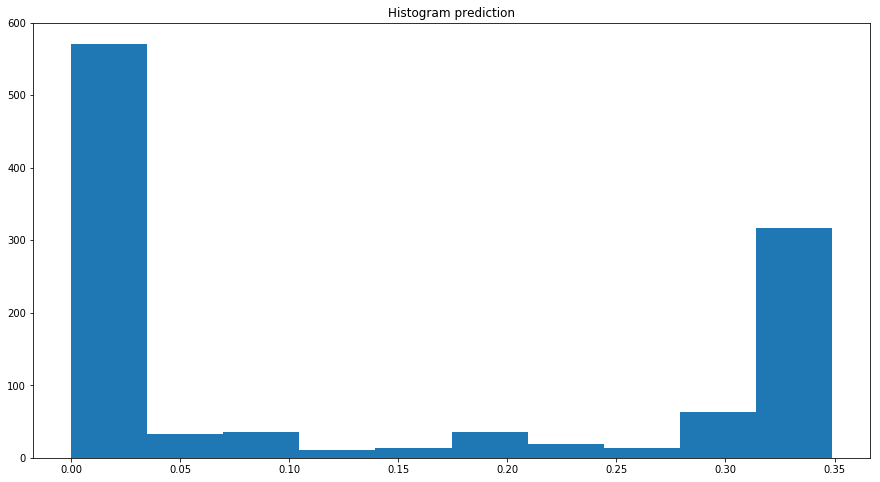

In [16]:
plt.figure(figsize=(15,8))
plt.title('Histogram prediction')
plt.hist(prediction)

In [17]:
prediction_bin = prediction > 0.5
prediction_bin = prediction_bin.astype(int)
confusion_matrix(y_test, prediction_bin)

array([[945,   0],
       [165,   0]])

Test only with Class : 0

In [18]:
df_test_0_only = df_test_0.sample(100)
X_test_0 = df_test_0_only.drop(['title', 
                                 'attack', 
                                 'attack_ID',
                                 'vmaf'], axis=1)
y_test_0 = df_test_0_only['attack_ID']
X_test_0 = np.asarray(X_test_0)
y_test_0 = np.asanyarray(y_test_0)

In [19]:
model.evaluate(X_test_0, y_test_0)

100/100 [==============================] - 0s 30us/step


[0.12668779373168945, 1.0]

In [20]:
prediction_0 = model.predict(X_test_0)
prediction_0_bin = prediction_0 > 0.5
prediction_0_bin = prediction_0_bin.astype(int)
confusion_matrix(y_test_0, prediction_0_bin)

array([[100]])

Text(0.5,1,'Histogram prediction')

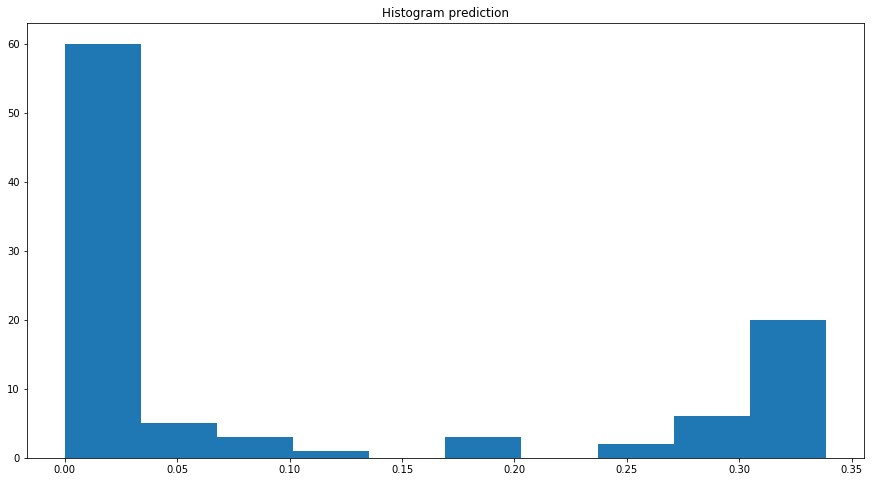

In [21]:
plt.figure(figsize=(15,8))
plt.hist(prediction_0)
plt.title('Histogram prediction')


In [22]:
X_test_all = df_test_all.drop(['title', 
                             'attack', 
                             'attack_ID',
                             'vmaf'],axis=1)
y_test_all = df_test_all['attack_ID']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

In [23]:
model.evaluate(X_test_all,y_test_all)

1160/1160 [==============================] - 0s 13us/step


[0.54554850726292048, 0.85775862068965514]

In [24]:
prediction_all = model.predict(X_test_all)

(array([ 599.,   36.,   35.,   12.,   13.,   38.,   19.,   14.,   65.,  329.]),
 array([ 0.        ,  0.03488539,  0.06977078,  0.10465617,  0.13954157,
         0.17442696,  0.20931235,  0.24419774,  0.27908313,  0.31396852,
         0.34885392]),
 <a list of 10 Patch objects>)

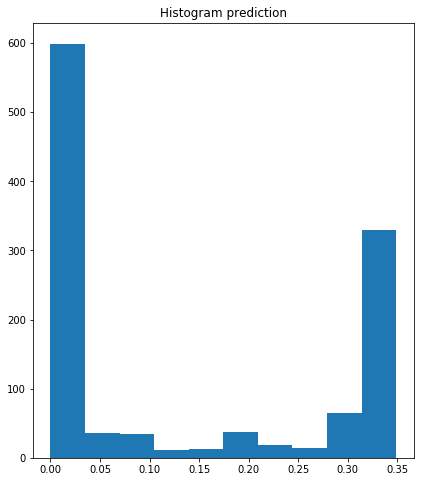

In [25]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title('Histogram prediction')
plt.hist(prediction_all)

In [26]:
prediction_all_bin = prediction_all > 0.5
prediction_all_bin = prediction_all_bin.astype(int)
confusion_matrix(y_test_all, prediction_all_bin)

array([[995,   0],
       [165,   0]])

# Random forest with scikit-learn

In [27]:
random_forest = RandomForestClassifier(n_estimators=15,)
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
random_forest.score(X_test,y_test)

0.9387387387387387

In [29]:
prediction_RF = random_forest.predict(X_test)

In [30]:
confusion_matrix(y_test, prediction_RF)

array([[902,  43],
       [ 25, 140]])

In [31]:
random_forest.score(X_test_0,y_test_0)

0.95999999999999996

In [32]:
prediction_RF_0 = random_forest.predict(X_test_0)
confusion_matrix(y_test_0,prediction_RF_0)

array([[96,  4],
       [ 0,  0]])

In [33]:
random_forest.score(X_test_all,y_test_all)

0.94137931034482758

In [34]:
prediction_RF_all = random_forest.predict(X_test_all)
confusion_matrix(y_test_all, prediction_RF_all)

array([[952,  43],
       [ 25, 140]])

# AdaBoost with scikit-learn

In [35]:
AdaBoost = AdaBoostClassifier(learning_rate=0.1)
AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)

In [36]:
AdaBoost.score(X_test, y_test)

0.92522522522522521

In [37]:
prediction_AdaBoost = AdaBoost.predict(X_test)

In [38]:
confusion_matrix(y_test, prediction_AdaBoost)

array([[902,  43],
       [ 40, 125]])

In [39]:
AdaBoost.score(X_test_0,y_test_0)

0.95999999999999996

In [40]:
prediction_AdaBoost_0 = AdaBoost.predict(X_test_0)
confusion_matrix(y_test_0,prediction_AdaBoost_0)

array([[96,  4],
       [ 0,  0]])

In [41]:
AdaBoost.score(X_test_all,y_test_all)

0.92672413793103448

In [42]:
prediction_AdaBoost_all = AdaBoost.predict(X_test_all)
confusion_matrix(y_test_all, prediction_AdaBoost_all)

array([[950,  45],
       [ 40, 125]])

# SVM with scikit-learn

In [43]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [44]:
classifier = svm.SVC(kernel='rbf')
classifier.fit(X_train, y_train)
prediction_SVM = classifier.predict(X_test)

In [45]:
classifier.score(X_test,y_test)

0.89549549549549545

In [46]:
confusion_matrix(y_test, prediction_SVM)

array([[917,  28],
       [ 88,  77]])

In [47]:
classifier.score(X_test_0,y_test_0)

1.0

In [48]:
prediction_SVM_0 = classifier.predict(X_test_0)
confusion_matrix(y_test_0,prediction_SVM_0)

array([[100]])

In [49]:
classifier.score(X_test_all,y_test_all)

0.85775862068965514

In [50]:
prediction_SVM_all = classifier.predict(X_test_all)
confusion_matrix(y_test_all, prediction_SVM_all)

array([[995,   0],
       [165,   0]])